## Installation - Loading the Gymnasium custom environment: LifeSim

Since we're using a custom environment, we need to install its package into the pip environment, such that it will be usable from the gymnasium library. The following code is based on a Google Colab's run.

In [1]:
'''
# %%capture
#!rm -rf /content/gym_projects
!unzip - o / content/archive.zip
!pip uninstall - -no-input life-sim
!pip install - -no-input - e / content/gym_projects/
'''

'\n# %%capture\n#!rm -rf /content/gym_projects\n!unzip - o / content/archive.zip\n!pip uninstall - -no-input life-sim\n!pip install - -no-input - e / content/gym_projects/\n'

If the environment cannot be made with gymnasium.make(), it may be useful to restart the runtime.

In [2]:
'''
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

restart_runtime()
'''


'\nimport os\n\ndef restart_runtime():\n  os.kill(os.getpid(), 9)\n\nrestart_runtime()\n'

## Creating the environment

In [3]:
import gymnasium as gym
import gymnasium.vector
import numpy as np
import tensorflow as tf
#from tensorflow import keras
#from keras import initializers
from collections import deque
import random
from life_sim.envs import LifeSim
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from agent import DQN_Agent, Agent, PPO_Agent
import agent
#from tensorflow import GradientTape
import memory
import importlib
importlib.reload(gym)
importlib.reload(memory)
importlib.reload(agent)

# Load the TensorBoard notebook extension
#%load_ext tensorboard
import datetime
log_dir = "logs/scalars/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = tf.summary.create_file_writer(log_dir)
# Clear any logs from previous runs
#%rm -rf ./logs/

2023-06-18 11:44:06.762684: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-18 11:44:07.485292: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-06-18 11:44:09.203836: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-06-18 11:44:09.203861: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: besaro
2023-06-18 11:44:09.203866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: besaro
2023-06-18 11:44:09.203919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 530.41.3
2

In [4]:

#tf.debugging.set_log_device_placement(True)
'''
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass
'''

"\nphysical_devices = tf.config.list_physical_devices('GPU')\ntry:\n  tf.config.experimental.set_memory_growth(physical_devices[0], True)\nexcept:\n  # Invalid device or cannot modify virtual devices once initialized.\n  pass\n"

Adding some useful settings and dictionaries to ease the code

In [5]:
# numpy settings for printing the states, if needed
np.set_printoptions(precision=4)

# some useful dictionaries used to let the code be more readable
# and less error-prone
num_actions = 3

actions = {
    "work": 0,
    "sport": 1,
    "sociality": 2
}

actions_array = {
    0: np.transpose([1, 0, 0]),
    1: np.transpose([0, 1, 0]),
    2: np.transpose([0, 0, 1]),
}

state_map = {
    "money": 0,
    "health": 1,
    "work development": 2,
    "social development": 3,
}

### Utils

Here we code some useful functions to visualize the results of the training and evaluate the model performance on the environment.

In [6]:
def plot_results(observations, rewards):
    # Plotting the first set of data
    performances = np.transpose(observations)
    plt.figure(1)
    plt.plot(performances[state_map['money']], label='Money')
    plt.plot(performances[state_map['health']], label='Health')
    plt.plot(performances[state_map['work development']],
             label='Work Development')
    plt.plot(performances[state_map['social development']],
             label='Social Development')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('State plot')
    plt.legend()

    # Plotting the second set of data
    plt.figure(2)
    plt.plot(rewards, label='Reward')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Rewards plot')
    plt.legend()

    # Plotting the second set of data
    plt.figure(3)
    plt.plot(np.cumsum(rewards), label='Cumulative Reward')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('Cumulative reward plot')
    plt.legend()

    # Displaying the plots
    plt.show()


In [7]:
def training_results(rewards, actions, normalize=False):
    # Normalize the data
    actions = np.transpose(actions)

    if normalize:
        f = np.max(rewards)
        rewards = [r/f for r in rewards]
        f = np.max([np.max(actions[i]) for i in range(len(actions))])
        actions = [[a/f for a in actions[i]] for i in range(len(actions))]

    # Plotting the first set of data
    plt.figure(1)
    plt.plot(actions[0], label='Work')
    plt.plot(actions[1], label='Sport')
    plt.plot(actions[2], label='Sociality')
    plt.xlabel('Training Steps')
    plt.ylabel('Values')
    plt.xticks(np.arange(0, len(actions[0]), 1))
    plt.title('# of Actions, per training step')
    plt.legend()

    # Plotting the second set of data
    plt.figure(2)
    plt.plot(rewards, label='Cumulative Reward')
    plt.xlabel('Training Steps')
    plt.ylabel('Values')
    plt.xticks(np.arange(0, len(rewards), 1))
    plt.title('Cumulative Rewards plot, per training step')
    plt.legend()

    # Displaying the plots
    plt.show()


In [8]:
def plot_losses(actor_loss, critic_loss, logscale = False, reduce_n=None):

    if reduce_n is not None:
        actor_loss = np.array(actor_loss).reshape(-1, reduce_n).mean(axis=1)
        critic_loss = np.array(critic_loss).reshape(-1, reduce_n).mean(axis=1)

    plt.figure(1)
    plt.plot(actor_loss, label='Mean Actor Loss per Update')
    plt.xlabel('Updates')
    plt.xticks(np.arange(1,len(actor_loss),1))
    plt.ylabel('Mean loss')
    if logscale: plt.yscale('log')
    plt.title('Actor Loss Plot')
    plt.legend()

    plt.figure(2)
    plt.plot(critic_loss, label='Mean Critic Loss per Update')
    plt.xlabel('Updates')
    if logscale: plt.yscale('log')
    plt.xticks(np.arange(1,len(critic_loss),1))
    plt.ylabel('Mean loss')
    plt.title('Critic Loss Plot')
    plt.legend()

    # Displaying the plots
    plt.show()


### Training the Agent

In [9]:
def training_step(agent: Agent, batch_size):

    loss = agent.train(replay_buffer, batch_size)
    return loss


def add_cumulative_reward(cumulative_rewards, avg_sum_reward, sum_rewards, tau):

    avg_sum_reward = (avg_sum_reward*(tau - 1) + sum_rewards)/tau
    cumulative_rewards.append(avg_sum_reward)


def add_sum_action(sum_actions, avg_sum_actions, actions, tau):

    avg_sum_actions = (np.dot(avg_sum_actions, (tau - 1)) + actions)/tau
    sum_actions.append(avg_sum_actions)


def calc_epsilon(episode, n_episodes, decay):
    return max(1 - episode/(n_episodes*decay), 0.05)


In [10]:
def play_one_step(vec_env, v_actions, epsilon):

    next_states, rewards, terminateds, truncateds, infos = vec_env.step(v_actions)
    return next_states, rewards, terminateds, truncateds, infos, v_actions


In [11]:
def play_episodes(n_episodes, tau):
    # cumulative rewards averaged over tau episodes
    cumulative_rewards = []
    sum_actions = []

    avg_sum_reward = 0
    avg_sum_actions = np.transpose([0, 0, 0])

    for episode in tqdm(np.arange(1, n_episodes, 1), desc="Episodes", position=0):

        sum_rewards = 0
        actions = np.transpose([0, 0, 0])

        v_obs, v_info = vec_env.reset()

        for step in np.arange(1, max_steps, 1):

            epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

            actions = [dqn_agent.predict(o, 0.5) for o in obs]

            v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(
                vec_env, actions, epsilon)
            [replay_buffer.append((v_obs[i], v_action[i], v_reward[i],
                                  v_new_obs[i], v_terminated[i])) for i in range(len(obs))]

            sum_rewards = sum_rewards + np.sum(v_reward)
            actions = actions + actions_array[v_info['last_action']]

            []
            # env.render()
            # if terminated or truncated:
            #    break

        if episode % tau == 0:

            add_cumulative_reward(cumulative_rewards,
                                  avg_sum_reward, sum_rewards, tau)
            add_sum_action(sum_actions, avg_sum_actions, actions, tau)
        else:

            avg_sum_reward = (avg_sum_reward*(episode %
                              tau - 1) + sum_rewards)/(episode % tau)
            avg_sum_actions = (
                np.dot(avg_sum_actions, (episode % tau - 1)) + actions)/(episode % tau)

            if episode > 10 and episode % tau == 0:
                training_step(dqn_agent, batch_size)

    return cumulative_rewards, sum_actions


In [12]:
def play_steps(vec_env, max_steps, tau):
    # cumulative rewards averaged over tau episodes
    cumulative_rewards = []
    sum_actions = []

    avg_sum_reward = 0
    avg_sum_actions = np.transpose([0, 0, 0])

    steps = 0

    v_obs, v_info = vec_env.reset(seed=seeds)

    sum_rewards = 0
    actions = np.transpose([0, 0, 0])


    for steps in tqdm(np.arange(1, max_steps, 1), desc="Steps", position=0):

        epsilon = calc_epsilon(steps, max_steps, decay=0.8)
        v_actions = np.array([dqn_agent.predict(o, 0) for o in v_obs])
        #v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(vec_env, v_actions, epsilon)
        v_new_obs, v_reward, v_terminated, v_truncated, v_info, v_action = play_one_step(vec_env, v_actions, epsilon)

        # save in buffer for the resetted envs
        # different code because of the vec_env.step() behaviour in case of truncated or terminated episode
        resetted_envs = [i for i in range(len(v_truncated)) if v_truncated[i] or v_terminated[i]]
        replay_buffer.extend([(v_obs[i], v_action[i], v_reward[i], v_info['final_observation'][i], v_terminated[i]) for i in resetted_envs])

        # save in buffer
        not_resetted_envs = [i for i in range(len(v_truncated)) if not v_truncated[i] and not v_terminated[i]]
        replay_buffer.extend([(v_obs[i], v_action[i], v_reward[i], v_new_obs[i], v_terminated[i]) for i in not_resetted_envs])

        #sum_rewards = sum_rewards + np.sum(v_reward)
        #actions = actions + \
        #    actions_array[np.sum(v_info['last_action'], axis=1)]

        if steps % tau == 0:
            training_step(dqn_agent, batch_size)

    
    return cumulative_rewards, sum_actions


In [13]:
'''
from tensorflow.compat import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
'''

'\nfrom tensorflow.compat import ConfigProto\nfrom tensorflow.compat.v1 import InteractiveSession\n\nconfig = ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.2\nconfig.gpu_options.allow_growth = True\nsession = InteractiveSession(config=config)\n'

In [14]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300
num_envs = 32
seeds = [int(x) for x in np.random.randint(1, 100000 + 1, size=num_envs)]
env_max_timesteps = 300

# create the vectorized environment
vec_env = gymnasium.vector.make(
    'life_sim/LifeSim-v0', num_envs=num_envs, asynchronous=True, max_timesteps=env_max_timesteps)
#vec_env = gymnasium.vector.make(
#    'CartPole-v0', num_envs=num_envs, asynchronous=True)


In [15]:
input_shape = [vec_env.single_observation_space.shape[0]]
#input_shape = [vec_env.single_observation_space.shape[0]]
n_outputs = vec_env.single_action_space.n

In [16]:
num_steps = 100000
# discount
gamma = 0.55
# lambda is the GAE parameter
lmbda = 0.95
# clipping parameter
epsilon = 0.3
# entropy parameter
c2 = 0.005
batch_timesteps = 128
minibatch_size = 32
epochs = batch_timesteps // minibatch_size

lr_actor = 1e-2
lr_critic = 4e-2

In [17]:
'''
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.con
#import tensorflow as tf
#from tensorflow import keras
#from keras import initializersfig.experimental.VirtualDeviceConfiguration(memory_limit=1600)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)
'''

'\ngpus = tf.config.experimental.list_physical_devices(\'GPU\')\nif gpus:\n  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU\n  try:\n    tf.config.experimental.set_virtual_device_configuration(\n        gpus[0],\n        [tf.con\n#import tensorflow as tf\n#from tensorflow import keras\n#from keras import initializersfig.experimental.VirtualDeviceConfiguration(memory_limit=1600)])\n    logical_gpus = tf.config.experimental.list_logical_devices(\'GPU\')\n    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")\n  except RuntimeError as e:\n    # Virtual devices must be set before GPUs have been initialized\n    print(e)\n'

In [18]:
#ppo_critic_optimizer = keras.optimizers.AdamW(learning_rate=lr)
#ppo_actor_optimizer = keras.optimizers.AdamW(learning_rate=lr)

In [19]:
m = memory.Memory(num_envs = num_envs, obs_shape = vec_env.single_observation_space.shape, timesteps = batch_timesteps)

In [20]:
import agent
importlib.reload(agent)
ppo_agent = agent.PPO_Agent(input_shape, n_outputs, gamma, lmbda, epsilon, c2, lr_actor, lr_critic, log_dir)

In [21]:
#from agent import play_n_timesteps
mean_losses_actor, mean_losses_critic = ppo_agent.play_n_timesteps(vec_env, m, num_steps, batch_timesteps, minibatch_size, epochs)

  0%|          | 0/781 [00:00<?, ?it/s]

In [22]:
ppo_agent.save_models("first_train")

INFO:tensorflow:Assets written to: models/20230618-114417/actor-xxx/assets


INFO:tensorflow:Assets written to: models/20230618-114417/actor-xxx/assets


INFO:tensorflow:Assets written to: models/20230618-114417/critic-xxx/assets


INFO:tensorflow:Assets written to: models/20230618-114417/critic-xxx/assets


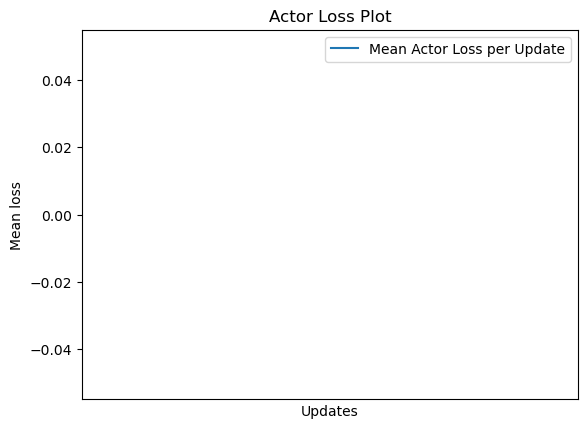

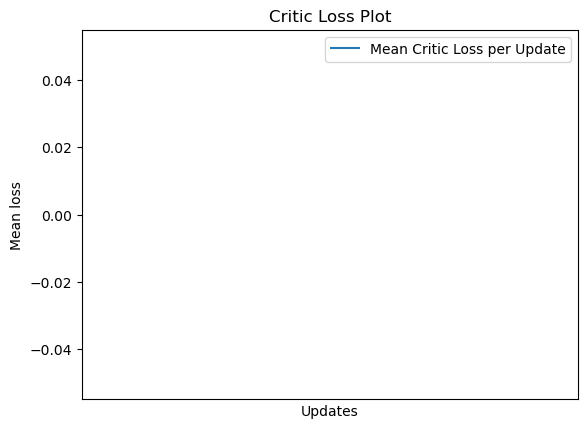

In [22]:
#plot_losses(mean_losses_actor, mean_losses_critic, logscale = False, reduce_n=None)

In [22]:
#%tensorboard --logdir log_dir

In [28]:
ppo_agent.actor.save_weights('actor_network_weights')
ppo_agent.critic.save_weights('critic_network_weights')

Evaluating the model for 200 episodes.

In [23]:
m.f_advantages[0:128]

array([-6.9678e-02, -6.9678e-02, -6.9678e-02, -6.9677e-02, -6.9677e-02,
       -6.9676e-02, -6.9675e-02, -6.9672e-02, -6.9666e-02, -6.9655e-02,
       -6.9634e-02, -6.9592e-02, -6.9510e-02, -6.9348e-02, -6.9031e-02,
       -6.8410e-02, -6.7191e-02, -6.4802e-02, -6.0118e-02, -5.0934e-02,
       -3.2925e-02,  2.3871e-03,  7.1626e-02,  2.0739e-01,  4.7359e-01,
        9.9555e-01,  2.0190e+00,  4.1262e+00, -6.9229e-02, -6.8797e-02,
       -6.7951e-02, -6.6291e-02, -6.3038e-02, -5.6658e-02, -4.4149e-02,
       -1.9621e-02,  2.8473e-02,  1.2278e-01,  3.0768e-01,  7.7066e-01,
       -6.8486e-02, -6.7341e-02, -6.5097e-02, -6.0695e-02, -5.2065e-02,
       -3.5144e-02, -1.9637e-03,  6.3095e-02,  1.9066e-01,  5.4121e-01,
       -6.9677e-02, -6.9677e-02, -6.9676e-02, -6.9674e-02, -6.9671e-02,
       -6.9665e-02, -6.9653e-02, -6.9629e-02, -6.9582e-02, -6.9490e-02,
       -6.9310e-02, -6.8957e-02, -6.8265e-02, -6.6907e-02, -6.4246e-02,
       -5.9027e-02, -4.8794e-02, -2.8728e-02,  1.0615e-02,  8.77

In [24]:
m.advantages.shape

(32, 128)

In [25]:
m.advantages[0,:128]

array([-6.9678e-02, -6.9678e-02, -6.9678e-02, -6.9677e-02, -6.9677e-02,
       -6.9676e-02, -6.9675e-02, -6.9672e-02, -6.9666e-02, -6.9655e-02,
       -6.9634e-02, -6.9592e-02, -6.9510e-02, -6.9348e-02, -6.9031e-02,
       -6.8410e-02, -6.7191e-02, -6.4802e-02, -6.0118e-02, -5.0934e-02,
       -3.2925e-02,  2.3871e-03,  7.1626e-02,  2.0739e-01,  4.7359e-01,
        9.9555e-01,  2.0190e+00,  4.1262e+00, -6.9229e-02, -6.8797e-02,
       -6.7951e-02, -6.6291e-02, -6.3038e-02, -5.6658e-02, -4.4149e-02,
       -1.9621e-02,  2.8473e-02,  1.2278e-01,  3.0768e-01,  7.7066e-01,
       -6.8486e-02, -6.7341e-02, -6.5097e-02, -6.0695e-02, -5.2065e-02,
       -3.5144e-02, -1.9637e-03,  6.3095e-02,  1.9066e-01,  5.4121e-01,
       -6.9677e-02, -6.9677e-02, -6.9676e-02, -6.9674e-02, -6.9671e-02,
       -6.9665e-02, -6.9653e-02, -6.9629e-02, -6.9582e-02, -6.9490e-02,
       -6.9310e-02, -6.8957e-02, -6.8265e-02, -6.6907e-02, -6.4246e-02,
       -5.9027e-02, -4.8794e-02, -2.8728e-02,  1.0615e-02,  8.77

In [26]:
m.f_returns[:128]

array([ 4.2942e-06,  7.1570e-06,  1.1928e-05,  1.9881e-05,  3.3134e-05,
        5.5224e-05,  9.2040e-05,  1.5340e-04,  2.5567e-04,  4.2611e-04,
        7.1018e-04,  1.1836e-03,  1.9727e-03,  3.2879e-03,  5.4798e-03,
        9.1330e-03,  1.5222e-02,  2.5369e-02,  4.2282e-02,  7.0471e-02,
        1.1745e-01,  1.9575e-01,  3.2625e-01,  5.4376e-01,  9.0626e-01,
        1.5104e+00,  2.5174e+00,  4.1956e+00,  3.0465e-03,  5.0775e-03,
        8.4625e-03,  1.4104e-02,  2.3507e-02,  3.9178e-02,  6.5297e-02,
        1.0883e-01,  1.8138e-01,  3.0230e-01,  5.0384e-01,  8.3973e-01,
        6.1563e-03,  1.0261e-02,  1.7101e-02,  2.8501e-02,  4.7502e-02,
        7.9171e-02,  1.3195e-01,  2.1992e-01,  3.6653e-01,  6.1089e-01,
        1.6946e-05,  2.8244e-05,  4.7073e-05,  7.8454e-05,  1.3076e-04,
        2.1793e-04,  3.6321e-04,  6.0536e-04,  1.0089e-03,  1.6815e-03,
        2.8026e-03,  4.6710e-03,  7.7850e-03,  1.2975e-02,  2.1625e-02,
        3.6041e-02,  6.0069e-02,  1.0012e-01,  1.6686e-01,  2.78

In [27]:
m.returns.shape

(32, 128)

In [28]:
m.returns[0]

array([ 4.2942e-06,  7.1570e-06,  1.1928e-05,  1.9881e-05,  3.3134e-05,
        5.5224e-05,  9.2040e-05,  1.5340e-04,  2.5567e-04,  4.2611e-04,
        7.1018e-04,  1.1836e-03,  1.9727e-03,  3.2879e-03,  5.4798e-03,
        9.1330e-03,  1.5222e-02,  2.5369e-02,  4.2282e-02,  7.0471e-02,
        1.1745e-01,  1.9575e-01,  3.2625e-01,  5.4376e-01,  9.0626e-01,
        1.5104e+00,  2.5174e+00,  4.1956e+00,  3.0465e-03,  5.0775e-03,
        8.4625e-03,  1.4104e-02,  2.3507e-02,  3.9178e-02,  6.5297e-02,
        1.0883e-01,  1.8138e-01,  3.0230e-01,  5.0384e-01,  8.3973e-01,
        6.1563e-03,  1.0261e-02,  1.7101e-02,  2.8501e-02,  4.7502e-02,
        7.9171e-02,  1.3195e-01,  2.1992e-01,  3.6653e-01,  6.1089e-01,
        1.6946e-05,  2.8244e-05,  4.7073e-05,  7.8454e-05,  1.3076e-04,
        2.1793e-04,  3.6321e-04,  6.0536e-04,  1.0089e-03,  1.6815e-03,
        2.8026e-03,  4.6710e-03,  7.7850e-03,  1.2975e-02,  2.1625e-02,
        3.6041e-02,  6.0069e-02,  1.0012e-01,  1.6686e-01,  2.78

In [29]:
m.f_returns.shape[0]/32 # steps per env (obviously)

128.0

In [30]:
m.terminateds.shape

(128, 32)

In [31]:
m.probs[:,0]

array([0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3437, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.4636, 0.9982, 1.    ,
       0.3332, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.2034, 0.3515, 0.3354, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.0164, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3268, 0.594 , 0.3256, 0.5861, 0.3123, 0.3044, 0.405 , 0.3818,
       0.3205, 0.3315, 0.3151, 0.3058, 0.3294, 0.3333, 0.2569, 0.2381,
       0.3202, 0.3333, 0.3415, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.4449, 0.3333, 0.3333, 0.311 , 0.3331, 0.308 , 0.3062,
      

In [35]:
m.f_probs[:128]

array([0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3437, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.4636, 0.9982, 1.    ,
       0.3332, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.2034, 0.3515, 0.3354, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.0164, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3268, 0.594 , 0.3256, 0.5861, 0.3123, 0.3044, 0.405 , 0.3818,
       0.3205, 0.3315, 0.3151, 0.3058, 0.3294, 0.3333, 0.2569, 0.2381,
       0.3202, 0.3333, 0.3415, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.4449, 0.3333, 0.3333, 0.311 , 0.3331, 0.308 , 0.3062,
      

In [32]:
m.probs.transpose().reshape((-1))[:128]

array([0.6021, 0.2032, 0.6024, 0.2028, 0.6031, 0.2285, 0.5521, 0.2283,
       0.5549, 0.2269, 0.5577, 0.5491, 0.5414, 0.2321, 0.5442, 0.2301,
       0.2262, 0.2225, 0.2179, 0.2133, 0.2076, 0.2018, 0.1967, 0.1907,
       0.2317, 0.2263, 0.2217, 0.216 , 0.2102, 0.5899, 0.2097, 0.5907,
       0.5813, 0.5719, 0.5632, 0.2227, 0.217 , 0.2125, 0.5851, 0.2121,
       0.2063, 0.599 , 0.2051, 0.5998, 0.5908, 0.5824, 0.574 , 0.5659,
       0.2203, 0.5684, 0.547 , 0.2299, 0.2261, 0.2205, 0.5702, 0.5617,
       0.2235, 0.2189, 0.5713, 0.5628, 0.2229, 0.2184, 0.2127, 0.5843,
       0.575 , 0.5665, 0.5579, 0.2244, 0.5582, 0.5515, 0.545 , 0.2303,
       0.5483, 0.2283, 0.2259, 0.5574, 0.5517, 0.5472, 0.5434, 0.5409,
       0.2291, 0.5403, 0.2295, 0.2273, 0.5465, 0.5446, 0.2271, 0.5503,
       0.5517, 0.5605, 0.5519, 0.5452, 0.2307, 0.2271, 0.5552, 0.5483,
       0.542 , 0.5366, 0.5326, 0.2352, 0.5321, 0.2352, 0.5363, 0.2334,
       0.2296, 0.2256, 0.2219, 0.2198, 0.2149, 0.5796, 0.5735, 0.5553,
      

In [33]:
m.actions.shape

(128, 32)

In [36]:
m.actions[:,0]

array([0., 1., 2., 0., 0., 1., 0., 0., 0., 1., 0., 1., 2., 2., 1., 0., 1.,
       0., 0., 0., 2., 2., 0., 1., 0., 1., 2., 2., 0., 2., 2., 2., 1., 0.,
       0., 2., 2., 0., 0., 0., 2., 2., 2., 0., 1., 2., 2., 0., 2., 2., 0.,
       0., 2., 1., 0., 2., 2., 0., 2., 2., 0., 1., 1., 0., 0., 1., 1., 1.,
       0., 2., 1., 1., 2., 2., 0., 1., 2., 1., 2., 1., 1., 0., 1., 0., 2.,
       1., 0., 0., 2., 1., 1., 2., 2., 1., 2., 1., 2., 1., 0., 2., 2., 0.,
       2., 1., 1., 0., 2., 1., 2., 1., 2., 2., 1., 1., 2., 1., 2., 1., 0.,
       0., 0., 2., 1., 1., 0., 2., 1., 2.], dtype=float32)

In [35]:
m.f_actions[:128]

array([0., 2., 0., 2., 0., 1., 0., 2., 0., 2., 0., 0., 0., 2., 0., 2., 1.,
       1., 1., 2., 2., 2., 1., 1., 2., 1., 2., 2., 1., 0., 1., 0., 0., 0.,
       0., 2., 1., 1., 0., 2., 2., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 2., 2., 0., 0., 1., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 2., 2., 2., 1., 2., 2., 0., 0., 0., 1., 0., 0., 2., 0., 2., 2.,
       2., 0., 2., 0., 0., 0., 1., 0., 1.], dtype=float32)

In [36]:
# this is the code in the memory class
# looks like it's working here, but not on the memory class.... WTF
m.actions.transpose().reshape((-1,))[:128]

array([0., 2., 0., 2., 0., 1., 0., 2., 0., 2., 0., 0., 0., 2., 0., 2., 1.,
       1., 1., 2., 2., 2., 1., 1., 2., 1., 2., 2., 1., 0., 1., 0., 0., 0.,
       0., 2., 1., 1., 0., 2., 2., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 2., 2., 0., 0., 1., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 2., 2., 2., 1., 2., 2., 0., 0., 0., 1., 0., 0., 2., 0., 2., 2.,
       2., 0., 2., 0., 0., 0., 1., 0., 1.], dtype=float32)

In [37]:
m.actions.transpose().reshape((-1))[:128]

array([0., 2., 0., 2., 0., 1., 0., 2., 0., 2., 0., 0., 0., 2., 0., 2., 1.,
       1., 1., 2., 2., 2., 1., 1., 2., 1., 2., 2., 1., 0., 1., 0., 0., 0.,
       0., 2., 1., 1., 0., 2., 2., 0., 2., 0., 0., 0., 0., 0., 2., 0., 0.,
       1., 2., 2., 0., 0., 1., 1., 0., 0., 1., 2., 1., 0., 0., 0., 0., 1.,
       0., 0., 0., 2., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 2., 1., 0.,
       0., 2., 0., 0., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0., 1., 0., 2.,
       0., 2., 2., 2., 1., 2., 2., 0., 0., 0., 1., 0., 0., 2., 0., 2., 2.,
       2., 0., 2., 0., 0., 0., 1., 0., 1.], dtype=float32)

In [37]:
m.values[:,0]

array([0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
      

In [40]:
m.f_values[:128]

array([0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
       0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
      

In [40]:
m.values.transpose().reshape((-1))[:128]

array([0.587 , 0.5999, 0.5726, 0.5855, 0.5582, 0.6266, 0.629 , 0.6418,
       0.6146, 0.6275, 0.6002, 0.6131, 0.6259, 0.6388, 0.6115, 0.6244,
       0.5971, 0.5995, 0.6019, 0.6043, 0.5771, 0.5499, 0.5226, 0.525 ,
       0.6217, 0.5945, 0.5969, 0.5697, 0.5425, 0.5449, 0.5577, 0.5601,
       0.5729, 0.5858, 0.5986, 0.6114, 0.5842, 0.5866, 0.589 , 0.6018,
       0.5746, 0.5474, 0.5602, 0.533 , 0.5459, 0.5587, 0.5715, 0.5844,
       0.5972, 0.57  , 0.629 , 0.6418, 0.6442, 0.617 , 0.5898, 0.6026,
       0.6155, 0.6178, 0.6202, 0.6331, 0.6459, 0.6483, 0.6211, 0.6235,
       0.6363, 0.6492, 0.662 , 0.6748, 0.6772, 0.6901, 0.7029, 0.7158,
       0.6885, 0.7014, 0.7038, 0.6765, 0.6894, 0.7022, 0.7151, 0.7279,
       0.7407, 0.7431, 0.756 , 0.7288, 0.7311, 0.744 , 0.7568, 0.7296,
       0.7424, 0.6379, 0.6508, 0.6636, 0.6764, 0.6788, 0.6516, 0.6644,
       0.6773, 0.6901, 0.703 , 0.7158, 0.7182, 0.731 , 0.7038, 0.7167,
       0.6894, 0.6622, 0.635 , 0.6374, 0.6101, 0.5829, 0.5958, 0.6546,
      

In [41]:
m.probs[:,0]

array([0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3437, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.4636, 0.9982, 1.    ,
       0.3332, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.2034, 0.3515, 0.3354, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.0164, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3268, 0.594 , 0.3256, 0.5861, 0.3123, 0.3044, 0.405 , 0.3818,
       0.3205, 0.3315, 0.3151, 0.3058, 0.3294, 0.3333, 0.2569, 0.2381,
       0.3202, 0.3333, 0.3415, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.4449, 0.3333, 0.3333, 0.311 , 0.3331, 0.308 , 0.3062,
      

In [42]:
m.f_probs[:128]

array([0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3437, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.4636, 0.9982, 1.    ,
       0.3332, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.2034, 0.3515, 0.3354, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.0164, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3268, 0.594 , 0.3256, 0.5861, 0.3123, 0.3044, 0.405 , 0.3818,
       0.3205, 0.3315, 0.3151, 0.3058, 0.3294, 0.3333, 0.2569, 0.2381,
       0.3202, 0.3333, 0.3415, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.4449, 0.3333, 0.3333, 0.311 , 0.3331, 0.308 , 0.3062,
      

In [ ]:
m.probs.transpose().reshape((-1))[:128]

array([0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
       0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
      

In [ ]:
m.probs[0,1]

0.28358233

In [ ]:
m.probs.reshape((1,-1))[:,:128]

array([[0.3003, 0.2836, 0.3995, 0.3346, 0.3232, 0.3698, 0.3255, 0.3719,
        0.2723, 0.2726, 0.3323, 0.3303, 0.2787, 0.3289, 0.3398, 0.3664,
        0.261 , 0.3925, 0.309 , 0.2998, 0.3869, 0.4668, 0.2668, 0.3899,
        0.4066, 0.376 , 0.3313, 0.2672, 0.2796, 0.3126, 0.3172, 0.3976,
        0.354 , 0.4179, 0.3963, 0.3327, 0.3229, 0.371 , 0.3321, 0.3711,
        0.2715, 0.395 , 0.2715, 0.4043, 0.4219, 0.3759, 0.3379, 0.3858,
        0.3646, 0.2767, 0.3173, 0.3158, 0.3474, 0.2763, 0.272 , 0.3356,
        0.3527, 0.2921, 0.3979, 0.3942, 0.2743, 0.3205, 0.3354, 0.2658,
        0.3052, 0.4377, 0.393 , 0.2672, 0.3308, 0.3242, 0.3304, 0.3691,
        0.2698, 0.2726, 0.3993, 0.3564, 0.4435, 0.2894, 0.3357, 0.2926,
        0.2638, 0.3909, 0.3778, 0.3107, 0.3087, 0.3096, 0.3067, 0.3929,
        0.4103, 0.3656, 0.3954, 0.3921, 0.2928, 0.3276, 0.3553, 0.3957,
        0.3477, 0.255 , 0.3904, 0.4027, 0.338 , 0.2784, 0.2697, 0.3672,
        0.267 , 0.3931, 0.3963, 0.3721, 0.465 , 0.2973, 0.265 , 

In [ ]:
m.obss.shape

(128, 32, 4)

In [ ]:
m.obss[:3,0,:]

array([[2.3163, 1.9408, 1.7035, 2.4027],
       [2.8163, 1.6408, 1.9335, 2.3027],
       [2.3163, 1.3408, 1.8635, 2.6027]], dtype=float32)

In [ ]:
m.f_obss[:3]

array([[2.3163, 1.9408, 1.7035, 2.4027],
       [1.0204, 5.0245, 3.3897, 1.1707],
       [2.9694, 2.9082, 2.8612, 1.9701]], dtype=float32)

In [ ]:
m.obss.reshape()

array([[2.5714, 2.0714, 1.5714, 1.0714],
       [1.5714, 2.0714, 2.5714, 3.0714],
       [3.5714, 4.0714, 3.5714, 3.0714]], dtype=float32)

In [ ]:
m.probs.shape

(128, 32)

In [116]:
ttt = np.ndarray((3,2))
ttt[0] = [0,10]
ttt[1] = [1,11]
ttt[2] = [2,12]
ttt.shape

(3, 2)

In [117]:
ttt

array([[ 0., 10.],
       [ 1., 11.],
       [ 2., 12.]])

In [118]:
ttt.reshape(-1)

array([ 0., 10.,  1., 11.,  2., 12.])

In [43]:
m.terminateds[:,0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [44]:
m.f_terminateds[:128]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [45]:
m.terminateds.transpose().reshape((-1,))[:128]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [46]:
m.truncateds.shape

(128, 32)

In [47]:
m.truncateds[:,3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [48]:
m.f_truncateds[128:128*2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [52]:
m.rewards[:,0]

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  4.1956,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.8397,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.6109,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  1.2875,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    , -1.2839,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    , -1.9796,  0.    ,  0.    ,
        0.    ,  0. 

In [51]:
m.rewards.transpose().reshape((-1))[:128]

array([ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  4.1956,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.8397,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.6109,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  1.2875,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    , -1.2839,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    , -1.9796,  0.    ,  0.    ,
        0.    ,  0. 

In [25]:
m.rewards.flatten('F')[:128]

array([ 0.    , -0.5367,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    , -1.6295,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    , -0.421 ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
       -0.7833,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    , -0.0937,  0.    ,  0.    ,  0.    ,
        0.    ,  0. 

In [26]:
m.f_rewards[:128]

array([ 0.    , -0.5367,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    , -1.6295,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    , -0.421 ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
       -0.7833,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    , -0.0937,  0.    ,  0.    ,  0.    ,
        0.    ,  0. 

In [120]:
m.obss.shape

(128, 32, 4)

In [143]:
x = np.moveaxis(np.moveaxis(m.obss,1,0),2,1).flatten('F')

In [145]:
x = np.moveaxis(m.obss,1,0)

In [147]:
x.shape

(32, 128, 4)

In [152]:
x.reshape((-1,)+vec_env.single_observation_space.shape)[:3]

array([[2.5714, 3.6694, 1.8007, 2.1109],
       [2.0714, 3.3694, 1.7307, 2.4109],
       [1.5714, 4.0694, 1.6607, 2.3109]], dtype=float32)

In [33]:
x = np.moveaxis(m.obss, 1, 0).reshape((-1,) + vec_env.single_observation_space.shape)[:3]
x

array([[1.    , 4.3959, 2.4056, 2.266 ],
       [0.5   , 4.0959, 2.3356, 2.566 ],
       [3.0102, 2.7857, 1.8027, 2.2925]], dtype=float32)

In [140]:
np.moveaxis(np.moveaxis(m.obss,1,0),2,1).flatten('F').shape

(16384,)

In [221]:
np.moveaxis(np.moveaxis(m.obss,1,0),2,1).reshape((-1,) + vec_env.single_observation_space.shape)[:3]

array([[2.3163, 2.8163, 2.3163, 1.8163],
       [1.3163, 0.8163, 1.3163, 0.8163],
       [1.3163, 0.8163, 1.3163, 1.8163]], dtype=float32)

In [ ]:
m.obss.moveaxis

In [142]:
m.obss.reshape(-1, m.obss.shape[-1])[:3]

array([[2.5714, 3.6694, 1.8007, 2.1109],
       [2.6939, 4.1796, 2.0729, 1.5939],
       [0.5   , 2.6714, 2.3563, 2.8027]], dtype=float32)

In [35]:
m.obss[:3,0,:]

array([[1.    , 4.3959, 2.4056, 2.266 ],
       [0.5   , 4.0959, 2.3356, 2.566 ],
       [3.0102, 2.7857, 1.8027, 2.2925]], dtype=float32)

In [36]:
m.f_obss[:3]

array([[1.    , 4.3959, 2.4056, 2.266 ],
       [0.5   , 4.0959, 2.3356, 2.566 ],
       [3.0102, 2.7857, 1.8027, 2.2925]], dtype=float32)

In [139]:
m.f_obss.shape

(4096, 4)

In [138]:
m.obss.flatten('F').shape

(16384,)

In [38]:
m.f_returns[:128]

array([-0.5314, -0.5367, -1.3063, -1.3195, -1.3328, -1.3463, -1.3599,
       -1.3736, -1.3875, -1.4015, -1.4156, -1.4299, -1.4444, -1.459 ,
       -1.4737, -1.4886, -1.5036, -1.5188, -1.5342, -1.5497, -1.5653,
       -1.5811, -1.5971, -1.6132, -1.6295, -0.3274, -0.3307, -0.3341,
       -0.3374, -0.3409, -0.3443, -0.3478, -0.3513, -0.3548, -0.3584,
       -0.362 , -0.3657, -0.3694, -0.3731, -0.3769, -0.3807, -0.3845,
       -0.3884, -0.3924, -0.3963, -0.4003, -0.4044, -0.4084, -0.4126,
       -0.4167, -0.421 , -0.6943, -0.7013, -0.7084, -0.7155, -0.7228,
       -0.7301, -0.7374, -0.7449, -0.7524, -0.76  , -0.7677, -0.7754,
       -0.7833, -0.0693, -0.07  , -0.0707, -0.0715, -0.0722, -0.0729,
       -0.0736, -0.0744, -0.0751, -0.0759, -0.0767, -0.0774, -0.0782,
       -0.079 , -0.0798, -0.0806, -0.0814, -0.0823, -0.0831, -0.0839,
       -0.0848, -0.0856, -0.0865, -0.0874, -0.0883, -0.0891, -0.09  ,
       -0.091 , -0.0919, -0.0928, -0.0937, -1.7563, -1.7741, -1.792 ,
       -1.8101, -1.8

In [49]:
ll = []
for xt in range(128):
    rr = 0
    for i in range(128-xt):
        if m.truncateds[i,0] or m.terminateds[i,0]:
            rr += m.f_rewards[127-i]
            #break
        else:
            rr += np.power(gamma, 128-i)*m.f_rewards[127-i]
    ll.append(rr) 

for j in range(len(ll)):
    print(ll[len(ll)-1-j])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [22]:

# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300

# create the vectorized environment
env = gymnasium.make('life_sim/LifeSim-v0', render_mode='text', max_timesteps=env_max_timesteps)

cumulative_rewards = []
sum_actions = []

avg_sum_reward = 0
avg_sum_actions = np.transpose([0, 0, 0])

n_episodes = 200

for episode in tqdm(np.arange(1, n_episodes+1, 1), desc="Episodes", position=0):

    #print(f"Episode {episode}")
    sum_rewards = 0
    actions = np.transpose([0, 0, 0])

    obs, info = env.reset()

    #for step in np.arange(1, max_steps, 1):
    while True:    
        epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

        action, _ , _= ppo_agent.get_action(obs[np.newaxis])

        action = action.numpy().squeeze().tolist()
        new_obs, reward, terminated, truncated, info = env.step(action)

        actions = actions + actions_array[action]

        sum_rewards += reward
#        actions = actions + actions_array[v_info['last_action']]

        #env.render()
        if terminated or truncated:
           break

    sum_actions.append(actions)
    cumulative_rewards.append(sum_rewards)

Episodes:   0%|          | 0/200 [00:00<?, ?it/s]

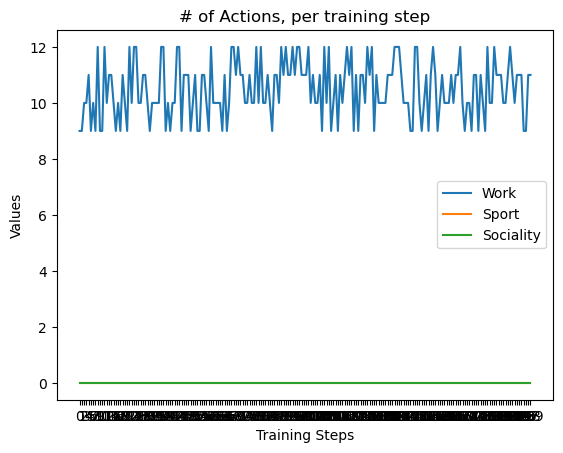

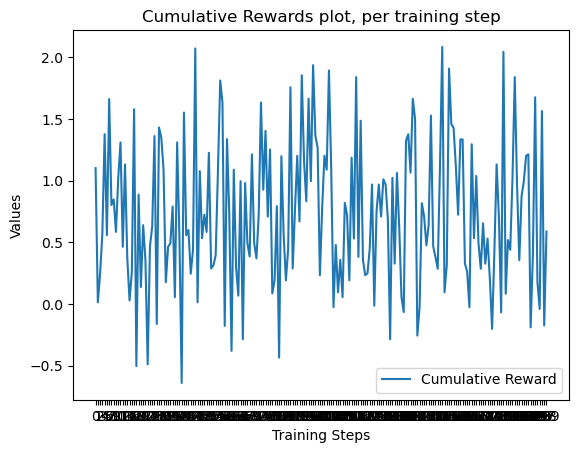

In [23]:
training_results(cumulative_rewards, sum_actions)

Let's print the mean of the cumulative rewards obtained in the previous 50 evaluated episodes:

In [24]:
print(np.mean(cumulative_rewards))

0.7269315195083618


In [25]:
# max number of steps for each episode of the simulator.
# if reached, the environment is TRUNCATED by the TimeLimit wrapper
#max_steps = 300

# create the vectorized environment
env = gymnasium.make('life_sim/LifeSim-v0', render_mode='text', max_timesteps=env_max_timesteps)

cumulative_rewards = []
sum_actions = []

avg_sum_reward = 0
avg_sum_actions = np.transpose([0, 0, 0])

n_episodes = 200

for episode in tqdm(np.arange(1, n_episodes+1, 1), desc="Episodes", position=0):

    #print(f"Episode {episode}")
    sum_rewards = 0
    actions = np.transpose([0, 0, 0])

    obs, info = env.reset()

    #for step in np.arange(1, max_steps, 1):
    while True:    
        epsilon = calc_epsilon(episode, n_episodes=n_episodes, decay=0.8)

        action = np.random.randint(3)

        new_obs, reward, terminated, truncated, info = env.step(action)

        actions = actions + actions_array[action]

        sum_rewards += reward
#        actions = actions + actions_array[v_info['last_action']]

        #env.render()
        if terminated or truncated:
           break

    sum_actions.append(actions)
    cumulative_rewards.append(sum_rewards)

Episodes:   0%|          | 0/200 [00:00<?, ?it/s]

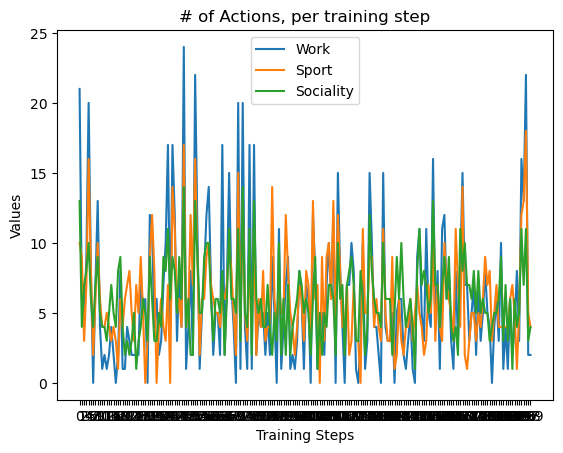

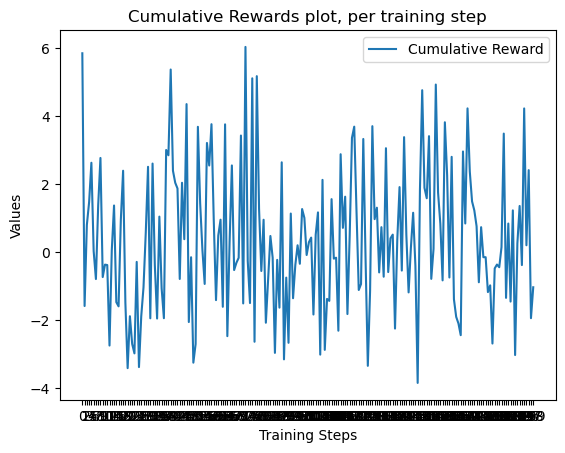

In [26]:
training_results(cumulative_rewards, sum_actions)

Let's print the mean of the cumulative rewards obtained in the previous 50 evaluated episodes, taking random actions:

In [27]:
print(np.mean(cumulative_rewards))

0.3524320387840271


Let's keep training, because the performance are pretty awful.

In [30]:
m.returns[0]

array([ 0.094 ,  0.1253,  0.0576,  0.0768,  0.1024,  0.1366,  0.1821,
        0.2428,  0.3238,  0.4317,  0.5756,  0.7674,  1.0233,  0.0103,
        0.0138,  0.0183,  0.0245,  0.0326,  0.0435,  0.058 ,  0.0773,
        0.1031,  0.1374,  0.0462,  0.0615,  0.0821,  0.1094,  0.1459,
        0.1945,  0.2593,  0.3458,  0.461 ,  0.6147,  0.8196,  1.0928,
        0.0287,  0.0383,  0.051 ,  0.068 ,  0.0907,  0.121 ,  0.1613,
        0.2151,  0.2867,  0.3823,  0.1002,  0.1336,  0.1782,  0.2375,
        0.3167,  0.4223,  0.5631,  0.7508,  1.001 ,  1.3347,  0.03  ,
        0.0401,  0.0534,  0.0712,  0.0949,  0.1266,  0.1688,  0.2251,
        0.3001,  0.4001,  0.5335,  0.0714,  0.0953,  0.127 ,  0.1693,
        0.2258,  0.301 ,  0.4014,  0.5352,  0.7136,  0.9514,  1.2686,
        1.6914,  0.0485,  0.0646,  0.0861,  0.1149,  0.1531,  0.2042,
        0.2722,  0.363 ,  0.484 ,  0.6453,  0.8604,  1.1472,  0.0599,
        0.0799,  0.1066,  0.1421,  0.1895,  0.2526,  0.3368,  0.4491,
        0.5988,  0.7

In [21]:
num_steps = 200000
# discount
gamma = 0.75
# lambda is the GAE parameter
lmbda = 0.95
# clipping parameter
epsilon = 0.1
# entropy parameter
c2 = 0.05
batch_timesteps = 128
minibatch_size = 32
epochs = batch_timesteps // minibatch_size

lr_actor = 1e-3
lr_critic = 6e-3

ppo_agent.actor.load_weights('actor_network_weights')
ppo_agent.critic.load_weights('critic_network_weights')

In [22]:
mean_losses_actor, mean_losses_critic = ppo_agent.play_n_timesteps(vec_env, m, num_steps, batch_timesteps, minibatch_size, epochs)

ppo_agent.actor.save_weights('checkpoints/actor/actor_network_weights_2')
ppo_agent.critic.save_weights('checkpoints/critic/critic_network_weights_2')

plot_losses(mean_losses_actor, mean_losses_critic, logscale = False, reduce_n=None)

  0%|          | 0/1562 [00:00<?, ?it/s]

2023-06-18 10:45:13.302969: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at sparse_xent_op.cc:102 : INVALID_ARGUMENT: Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3


InvalidArgumentError: {{function_node __wrapped__SparseSoftmaxCrossEntropyWithLogits_device_/job:localhost/replica:0/task:0/device:CPU:0}} Received a label value of 3 which is outside the valid range of [0, 3).  Label values: 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 [Op:SparseSoftmaxCrossEntropyWithLogits]

Here we should start training and testing the DQN

In [ ]:
tau = 100
max_steps = 1585

cumulative_rewards, sum_actions = play_steps(vec_env, max_steps, tau)
training_results(cumulative_rewards, sum_actions, normalize=True)

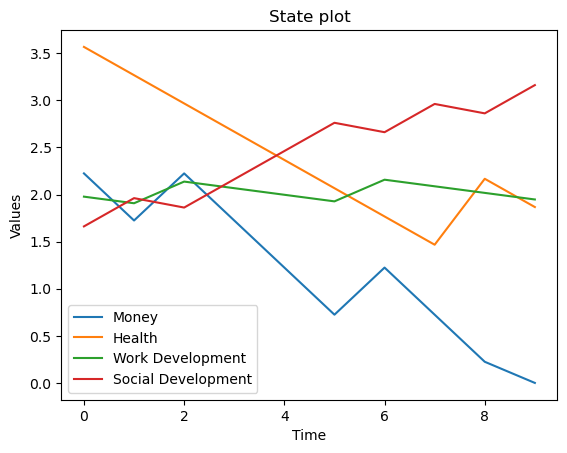

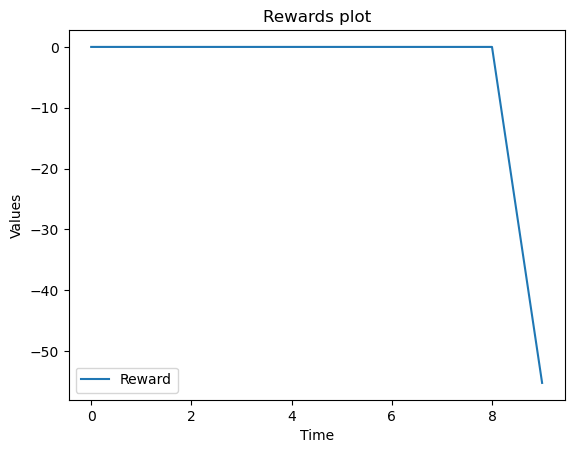

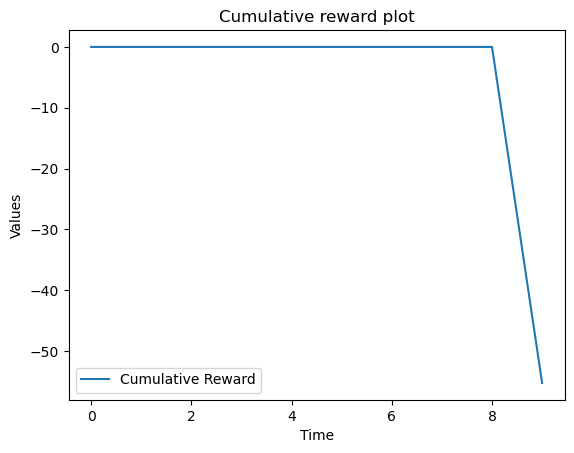

In [35]:
observations = []
rewards = []

obs, info = env.reset()

done = False
terminated = False
while not done and not terminated:
    obs, reward, terminated, truncated, info = env.step(np.random.randint(3))
    # print(np.array2string(obs))
    observations.append(obs)
    # print(np.array2string(reward))
    rewards.append(reward)
    if terminated or truncated:
        break

plot_results(observations, rewards)


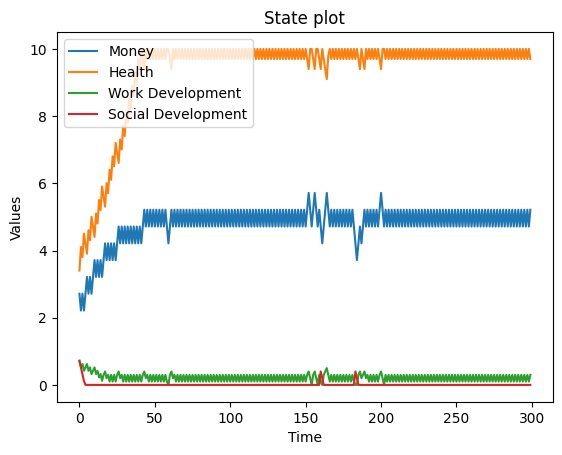

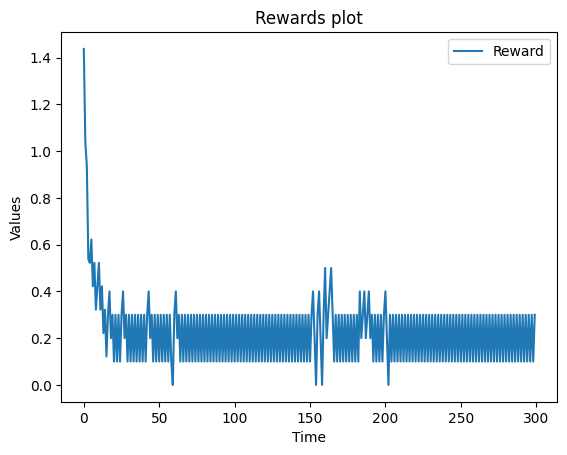

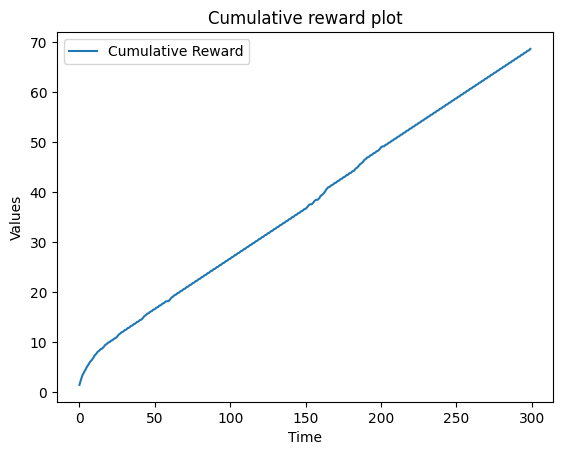

In [ ]:
observations = []
rewards = []

for episode in range(1):

    obs, info = env.reset()
    for step in range(1000):
        epsilon = 0.05
        obs, reward, terminated, truncated, info, action = dqn_agent.play_one_step(
            env, obs, epsilon)
        observations.append(obs)
        rewards.append(reward)
        # env.render()
        if terminated or truncated:
            break

plot_results(observations, rewards)
